In [29]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[2])

import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel,SplitOperatorPDEModel,OperatorPDEModel,build_batched_jac_func
from evaluation_metrics import compute_results    
from data_utils import MinMaxScaler
from evaluation_metrics import get_nrmse

from Kernels import log1pexp,inv_log1pexp
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM,SVD_LM,SketchedLM

In [30]:
import time
from jax.scipy.sparse.linalg import cg
from jax.scipy.linalg import solve,cho_factor,cho_solve

def SketchedCG_LM(
        init_params,
        model,
        beta,
        max_iter = 200, tol = 1e-8,
        cmin = 0.1,line_search_increase_ratio = 1.5,max_line_search_iterations = 20,
        min_alpha = 1e-6,
        max_alpha = 20.,
        init_alpha = 3.,
        step_adapt_multiplier = 1.2,
        callback = None,
        print_every = 50,
        track_iterates = False,
        sketch_size = 200,
        random_key = jax.random.PRNGKey(310)
        ):
    """Adaptively regularized Levenberg Marquadt optimizer
    TODO: Wrap up convergence data into a convergence_data dictionary or object
    Parameters
    ----------
    init_params : jax array
        initial guess
    model :
        Object that contains model.F, and model.jac, and model.damping_matrix
    beta : float
        (global) regularization strength
    max_iter : int, optional
        by default 200
    tol : float, optional
        Gradient norm stopping tolerance
    cmin : float, optional
        Minimum armijo ratio to accept step, by default 0.1
    line_search_increase_ratio : float, optional
        constant to increase reg strength by in backtracking line search, by default 1.5
    max_line_search_iterations : int, optional
        by default 20
    min_alpha : _type_, optional
        min damping strength, by default 1e-6
    max_alpha : _type_, optional
        max damping strength, by default 20.
    init_alpha : _type_, optional
        initial damping strength, by default 3.
    step_adapt_multipler : float, optional
        value to use for adapting alpha, by default 1.2
    callback : callable, optional
        function called to print another loss each iteration, by default None
    print_every : int, optional
        How often to print convergence data, by default 50
    

    Returns
    -------
    fitted_params
        optimized parameters
    convergence_data
        dictionary of convergence data
    """
    start_time = time.time()
    params = init_params.copy()

    residuals,F_vjp = jax.vjp(model.F,params)

    residuals = model.F(params)
    damping_matrix = model.damping_matrix(params)

    loss_vals = [
        (1/2)*jnp.sum(residuals**2) + (1/2)*beta * params.T@damping_matrix@params
    ]
    JtRes = [jnp.linalg.norm(F_vjp(residuals)[0] + beta * damping_matrix@params)]
    iterate_history = [params]
    improvement_ratios = []
    alpha_vals = []
    cumulative_time = []
    alpha = init_alpha

    key = random_key

    @jax.jit
    def sketch_objective(params,sketch):
        residuals,F_vjp = jax.vjp(model.F,params)
        SJ = jax.vmap(F_vjp)(sketch)[0]
        g = F_vjp(residuals)[0]
        return residuals,g,SJ
    
    @jax.jit
    def get_step(params,sketched_JtJ,alpha,damping_matrix,g,z):
        full_gradient = g + beta * z
        M = sketched_JtJ + (alpha + beta) * damping_matrix
        chol = cho_factor(M)
        init_step = cho_solve(chol,full_gradient)
        # fvals,Jstep = jax.jvp(model.F,(params,),(init_step,))
        # linear_residual = jax.vjp(model.F,params)[1](Jstep - fvals)[0] + beta * z - alpha*damping_matrix@step
        # step = step - cho_solve(chol,linear_residual)
        linop = (
            lambda x:
            jax.vjp(model.F,params)[1](jax.jvp(model.F,(params,),(x,))[1])[0] + alpha * damping_matrix@x
        )
        step,info = cg(linop,full_gradient,init_step,M = lambda x:cho_solve(chol,x),tol = 1e-1,maxiter = 50)

        return step


    def LevenbergMarquadtUpdate(params,alpha,sketch):
        residuals,g,SJ = sketch_objective(params,sketch)
        sketched_JtJ = SJ.T@SJ
        damping_matrix = model.damping_matrix(params)
        z = damping_matrix@params
        loss = (1/2)*jnp.sum(residuals**2) + (1/2)*beta * params.T@z
        full_gradient = g + beta * z

        for i in range(max_line_search_iterations):
            alpha =jnp.clip(alpha,min_alpha,max_alpha)

            #Step Computation Here
            step = get_step(params,sketched_JtJ,alpha,damping_matrix,g,z)
            #Step computation end
            

            new_params = params - step
            new_reg_norm = beta * new_params.T@damping_matrix@new_params
            new_loss = (1/2)*(jnp.sum(model.F(new_params)**2) + new_reg_norm)
            Jstep = jax.jvp(model.F,(params,),(step,))[1]

            predicted_loss = (1/2)*(jnp.sum((Jstep-residuals)**2) + new_reg_norm)

            improvement_ratio = (loss - new_loss)/(loss - predicted_loss)

            if improvement_ratio >= cmin and (new_loss < loss):
                #Check if we get at least some proportion of predicted improvement from local model
                succeeded = True
                return new_params, new_loss, full_gradient, improvement_ratio,alpha,succeeded
            else:
                alpha = line_search_increase_ratio * alpha
            succeeded = False
        return new_params, new_loss, full_gradient, improvement_ratio,alpha,succeeded

    for i in tqdm(range(max_iter)):
        sampling_key,key = jax.random.split(key)
        sketch = jax.random.normal(sampling_key,shape = (sketch_size,len(residuals)))/jnp.sqrt(sketch_size)
        params,loss,full_gradient,improvement_ratio,alpha,succeeded = LevenbergMarquadtUpdate(params,alpha,sketch)
        # Get new value for alpha
        multiplier = step_adapt_multiplier
        if improvement_ratio <= 0.2:
            alpha = multiplier * alpha
        if improvement_ratio >= 0.8:
            alpha = alpha/multiplier

        if succeeded==False:
            print("Line Search Failed!")
            print("Final Iteration Results")
            print(f"Iteration {i}, loss = {loss:.4}, Jres = {JtRes[-1]:.4}, alpha = {alpha:.4}")
            convergence_results = {
                "loss_vals":loss_vals,
                "norm_JtRes":JtRes,
                "armijo_ratios":improvement_ratios,
                "alpha_vals":alpha_vals,
                'time_spent':cumulative_time

            }
            return params,convergence_results
        cumulative_time.append(time.time()-start_time)
        loss_vals += [loss]
        JtRes += [jnp.linalg.norm(full_gradient)]
        iterate_history += [params]
        improvement_ratios +=[improvement_ratio]
        alpha_vals +=[alpha]
        if JtRes[-1]<=tol:
            break

        if i%print_every ==0 or i<=5:
            print(f"Iteration {i}, loss = {loss:.4}, Jres = {JtRes[-1]:.4}, alpha = {alpha:.4}, improvement_ratio = {improvement_ratio:.4}")
            if callback:
                callback(params)
    convergence_results = {
        "loss_vals":loss_vals,
        "norm_JtRes":JtRes,
        "armijo_ratios":improvement_ratios,
        "alpha_vals":alpha_vals,
        'time_spent':cumulative_time
    }
    if track_iterates is True:
        convergence_results['iterate_history']=iterate_history
    return params,convergence_results


In [31]:
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from scipy.spatial import distance
from matplotlib import cm
import time
from mpl_toolkits.mplot3d import Axes3D
# from pyDOE import lhs
# #    import sobol_seq
import os


In [32]:
def get_data_rand_coll(n_coll, n_obs,seed, data_for_pinn = False): 
    '''
    n_coll (int) : Integer less than 101 x 256.
    n_obs (int)    : Integet less than 101 x 256.
    seed (int)     : Seed to choose data point set.
    '''     
    # Generate data
    data = scipy.io.loadmat('/home/juanfelipe/Desktop/research/keql/examples/burgers/data/burgers.mat')
    # t
    t = jnp.real(data['t'].flatten()[:,None])
    # # Scale t
    # scaler_t = MinMaxScaler()
    # t = scaler_t.fit_transform(t)
    # x
    x = np.real(data['x'].flatten()[:,None])
    # # Scale x
    # scaler_x = MinMaxScaler()
    # x = scaler_x.fit_transform(x)
    # u true values
    Exact = np.real(data['usol'])

    # Fine meshgrid
    T, X = np.meshgrid(t,x)

    # Fine pairs (t,x)
    X_star = np.hstack((T.flatten()[:,None], X.flatten()[:,None]))
    # Fine u values
    u_star = Exact.flatten()[:,None]
    
    # Triples at collocation point set
    N_all = n_coll
    triplets_fine = np.hstack([X_star,u_star])
    triplets_all = jax.random.choice(key = jax.random.PRNGKey(0), a = triplets_fine, shape = (N_all,), replace=False)
    
    # Collocation point set
    tx_all = triplets_all[:,:2]


    N_obs = n_obs
    triplets_obs = jax.random.choice(key = jax.random.PRNGKey(seed), a = triplets_fine, shape = (N_obs,), replace=False)
    # triplets_obs = triplets_all[idx_obs,:] # Choose data point set from full point set
    # Data point set
    tx_obs = triplets_obs[:,:2]
    u_obs = triplets_obs[:,-1]

    u_star = triplets_fine[:,-1]

    # Invert them to be ready for PINNSR
    if data_for_pinn:
        tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

        tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

        tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

        X_star = X_star.at[:,[1,0]].set(X_star[:,[0,1]])

        triplets_fine = triplets_fine.at[:,[1,0]].set(triplets_fine[:,[0,1]])
    
    return tx_obs, u_obs, tx_all, u_star, X_star

In [33]:
def get_data_unif_coll(n_coll_t, n_coll_x, n_obs, seed, data_for_pinn = False):  
    '''
    n_coll_t (int) : Integer less than 101.
    n_coll_x (int) : Integer less than 256.
    n_obs (int)    : Integet less than n_coll_t x n_coll_x.
    seed (int)     : Seed to choose data point set.
    '''  
    data = scipy.io.loadmat('/home/juanfelipe/Desktop/research/keql/examples/burgers/data/burgers.mat')
    # t
    t = jnp.real(data['t'].flatten())
    # Scale t
    # scaler_t = MinMaxScaler()
    # t = scaler_t.fit_transform(t)
    # x
    x = jnp.real(data['x'].flatten())
    # Scale x
    # scaler_x = MinMaxScaler()
    # x = scaler_x.fit_transform(x)
    # u true values
    Exact = jnp.real(data['usol'])

    # Fine meshgrid
    T, X = jnp.meshgrid(t,x)

    # Fine pairs (t,x)
    X_star = jnp.hstack((T.flatten()[:,None], X.flatten()[:,None]))
    lb, ub = X_star.min(0), X_star.max(0)    
    # Fine u values
    u_star = Exact.flatten()[:,None]
    triplets_fine = jnp.hstack([X_star,u_star])


    # Triples at collocation point set
    idx_t_all = jnp.round(jnp.linspace(0, len(t) - 1, n_coll_t)).astype(int)
    t_all = t[idx_t_all]
    idx_x_all = jnp.round(jnp.linspace(0, len(x) - 1, n_coll_x)).astype(int)
    x_all = x[idx_x_all]
    # Collocation meshgrid
    T_all, X_all = jnp.meshgrid(t_all,x_all)
    # Collocation_pairs
    tx_all = np.hstack((T_all.flatten()[:,None], X_all.flatten()[:,None]))

    def is_in_array2(coords, array2):
        # Compare each coordinate pair to all rows in array2 and return True if it matches any row
        return jnp.any(jnp.all(coords == array2, axis=1))
    check_inclusion = jax.vmap(lambda row: is_in_array2(row[:2], tx_all))

    coords_to_check = triplets_fine[:,:2]
    triplets_all = triplets_fine[check_inclusion(coords_to_check)]

    # Collocation point set
    tx_all = triplets_all[:,:2]

    N_obs = n_obs
    triplets_obs = jax.random.choice(key = jax.random.PRNGKey(seed), a = triplets_all, shape = (N_obs,), replace=False)
    triplets_train = triplets_obs[:int(N_obs*0.8),:]
    triplets_val = triplets_obs[int(N_obs*0.8):,:]

    # Data point set
    tx_train = triplets_train[:,:2]
    u_train = triplets_train[:,-1]

    # Validation point set
    tx_val = triplets_val[:,:2]
    u_val = triplets_val[:,-1]


    # Invert them to be ready for PINNSR
    if data_for_pinn:
        tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

        tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

        tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

        X_star = X_star.at[:,[1,0]].set(X_star[:,[0,1]])

        triplets_fine = triplets_fine.at[:,[1,0]].set(triplets_fine[:,[0,1]])

    u_star = triplets_fine[:,-1]

    return tx_train, u_train, tx_val, u_val, tx_all, lb, ub, u_star, X_star

In [34]:
n_coll_t = 30
n_coll_x=30
n_obs = 50
run = 100

tx_obs, u_obs, tx_all, u_star, X_star = (
    get_data_rand_coll(n_coll = 2500,n_obs = n_obs,seed=run)
)
tx_all = jnp.vstack([tx_all,jnp.vstack([jnp.zeros(30),jnp.linspace(-8,8,30)]).T])

# # if using val
# tx_obs = jnp.vstack([tx_train,tx_val])
# u_obs  = jnp.concatenate([u_train,u_val]).flatten()    

# Run 1_5 step method

u_operators = (eval_k,)
feature_operators = (eval_k,dx_k,dxx_k)

# Choose u kernel
def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
ML_lengthscales = log1pexp(fitted_params)
print(1/(jnp.sqrt(ML_lengthscales)))
k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(jnp.array([1.,1.])))

# RKHS class for u
u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )
u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_all,u_params_init))
    .reshape(
            len(tx_all),
            len(feature_operators),
            order = 'F'
        )
)

# Choose kernel for P
k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])
P_model = OperatorModel(k_P)

[2.03724345 2.01946685]


In [35]:
# Equation model that has u and P object
EqnModel = SplitOperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_all,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100,
    jacobian_operator = build_batched_jac_func(100),
)

In [36]:
params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])
sketch_params,sketched_convergence_data = SketchedLM(
    params_init.copy(),
    EqnModel,
    beta = 0.,
    max_iter = 501,
    init_alpha=0.1,
    print_every = 100,
    sketch_size = 200,
)

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.001552, Jres = 8.748, alpha = 0.08333, improvement_ratio = 1.047
Iteration 1, loss = 0.001222, Jres = 3.462, alpha = 0.06944, improvement_ratio = 0.9025
Iteration 2, loss = 0.0009713, Jres = 2.214, alpha = 0.05787, improvement_ratio = 1.063
Iteration 3, loss = 0.0007795, Jres = 2.812, alpha = 0.04823, improvement_ratio = 1.033
Iteration 4, loss = 0.0006537, Jres = 2.196, alpha = 0.04019, improvement_ratio = 1.059
Iteration 5, loss = 0.0004923, Jres = 2.948, alpha = 0.03349, improvement_ratio = 0.9637
Iteration 100, loss = 5.27e-05, Jres = 0.02996, alpha = 0.05741, improvement_ratio = 1.002
Iteration 200, loss = 2.19e-05, Jres = 0.2503, alpha = 0.0115, improvement_ratio = 1.011
Iteration 300, loss = 1.567e-05, Jres = 0.1592, alpha = 0.01611, improvement_ratio = 0.9952
Iteration 400, loss = 1.29e-05, Jres = 0.08977, alpha = 0.01307, improvement_ratio = 0.9777
Iteration 500, loss = 1.105e-05, Jres = 0.1365, alpha = 0.04293, improvement_ratio = 1.006


In [37]:
params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])
spcg_params,cg_convergence_data = SketchedCG_LM(
    params_init.copy(),
    EqnModel,
    beta = 0.,
    max_iter = 201,
    init_alpha=0.1,
    print_every = 100,
    sketch_size = 200,
)

  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.001393, Jres = 8.748, alpha = 0.08333, improvement_ratio = 1.041
Iteration 1, loss = 0.001164, Jres = 1.451, alpha = 0.06944, improvement_ratio = 1.031
Iteration 2, loss = 0.0009497, Jres = 1.57, alpha = 0.05787, improvement_ratio = 1.037
Iteration 3, loss = 0.0007549, Jres = 1.86, alpha = 0.04823, improvement_ratio = 1.037
Iteration 4, loss = 0.0005902, Jres = 2.166, alpha = 0.04019, improvement_ratio = 1.027
Iteration 5, loss = 0.0004621, Jres = 2.7, alpha = 0.03349, improvement_ratio = 1.017
Iteration 100, loss = 3.077e-07, Jres = 0.002372, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 200, loss = 2.204e-07, Jres = 0.000884, alpha = 8.333e-07, improvement_ratio = 1.0


In [38]:
# Optimize - LM
params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])
full_jac_params,fulljac_convergence_data = CholeskyLM(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    max_iter = 51,
    init_alpha=0.1,
    line_search_increase_ratio=1.4,
    print_every = 10
)
# p_adjusted,refine_convergence_data = SVD_LM(params,EqnModel,1e-3,100,print_every = 10,overall_regularization=1e-15)
# # u_params
# u_sol = p_adjusted[:u_model.num_params]
# # u_true 
# u_true = u_star.flatten()
# # get error
# error_u_field = get_nrmse(u_true, u_model.point_evaluate(X_star,u_sol))

  0%|          | 0/51 [00:00<?, ?it/s]

Iteration 0, loss = 0.00139, Jres = 8.748, alpha = 0.08333, improvement_ratio = 1.033
Iteration 1, loss = 0.001159, Jres = 1.038, alpha = 0.06944, improvement_ratio = 1.023
Iteration 2, loss = 0.0009423, Jres = 1.505, alpha = 0.05787, improvement_ratio = 1.043
Iteration 3, loss = 0.0007462, Jres = 1.772, alpha = 0.04823, improvement_ratio = 1.037
Iteration 4, loss = 0.0005825, Jres = 2.121, alpha = 0.04019, improvement_ratio = 1.028
Iteration 5, loss = 0.0004567, Jres = 2.217, alpha = 0.03349, improvement_ratio = 1.015
Iteration 10, loss = 0.0001944, Jres = 0.8852, alpha = 0.01346, improvement_ratio = 0.9914
Iteration 20, loss = 6.5e-05, Jres = 0.6096, alpha = 0.002174, improvement_ratio = 1.017
Iteration 30, loss = 1.623e-05, Jres = 0.5707, alpha = 0.0003511, improvement_ratio = 1.005
Iteration 40, loss = 5.186e-06, Jres = 2.011, alpha = 5.67e-05, improvement_ratio = 0.9249
Iteration 50, loss = 1.497e-06, Jres = 2.743, alpha = 1.319e-05, improvement_ratio = 0.7397


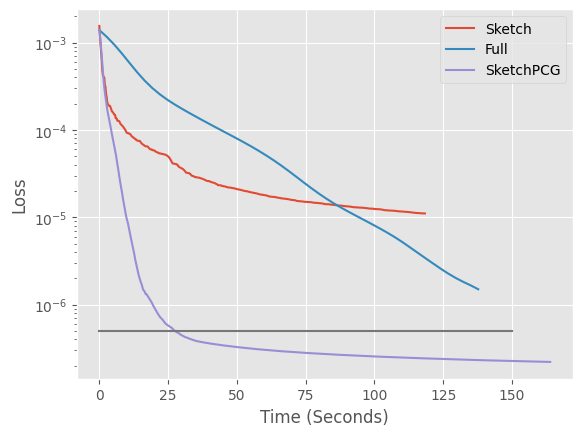

In [39]:
plt.plot(
    jnp.array(sketched_convergence_data['time_spent']) - jnp.array(sketched_convergence_data['time_spent'])[0],
    jnp.array(sketched_convergence_data['loss_vals'])[1:],
    label = 'Sketch'
    )
plt.plot(
    jnp.array(fulljac_convergence_data['time_spent']) - jnp.array(fulljac_convergence_data['time_spent'])[0],
    jnp.array(fulljac_convergence_data['loss_vals'])[1:],
    label = 'Full'
    )
plt.plot(
    jnp.array(cg_convergence_data['time_spent']) - jnp.array(cg_convergence_data['time_spent'])[0],
    jnp.array(cg_convergence_data['loss_vals'])[1:],
    label = 'SketchPCG')

plt.yscale('log')
plt.legend()
plt.xlabel("Time (Seconds)")
plt.plot([0,150],[5e-7,5e-7])
plt.ylabel("Loss")
plt.show()

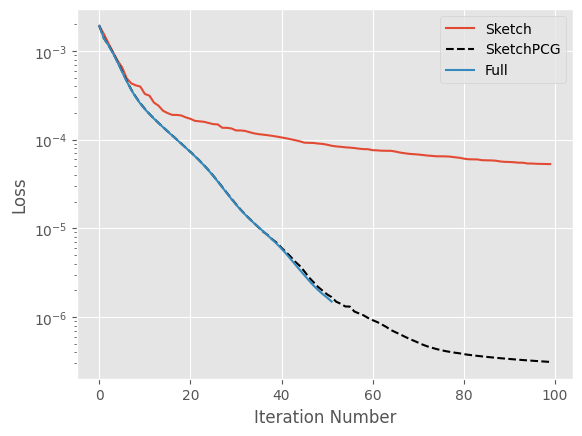

: 

In [44]:
plt.plot(
    jnp.array(sketched_convergence_data['loss_vals'])[:100],
    label = 'Sketch'
    )
plt.plot(
    jnp.array(cg_convergence_data['loss_vals'])[:100],
    label = 'SketchPCG',c='black',ls = '--')

plt.plot(
    jnp.array(fulljac_convergence_data['loss_vals'])[:100],
    label = 'Full'
    )

plt.yscale('log')
plt.legend()
plt.xlabel("Iteration Number")
plt.ylabel("Loss")
plt.show()

In [41]:
# u_params
u_sol = spcg_params[:u_model.num_params]
P_parameters = spcg_params[u_model.num_params:]
# u_true 
u_true = u_star.flatten()
# get error
error_u_field = get_nrmse(u_true, u_model.point_evaluate(X_star,u_sol))

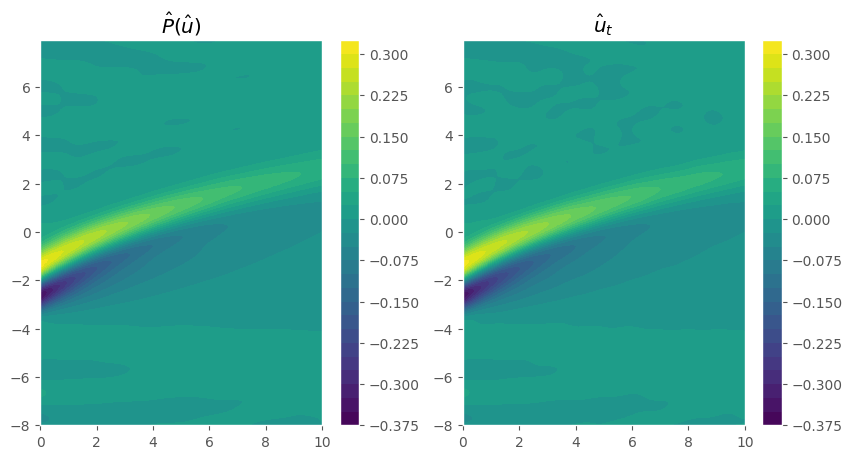

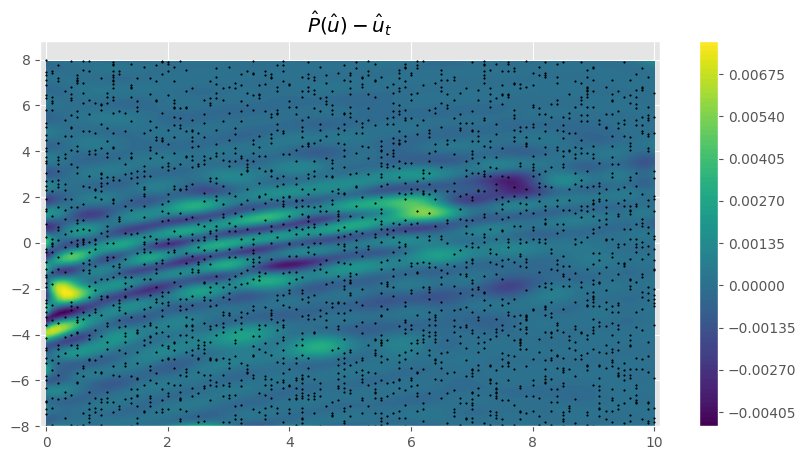

Equation fit error norm  0.14053984525378282


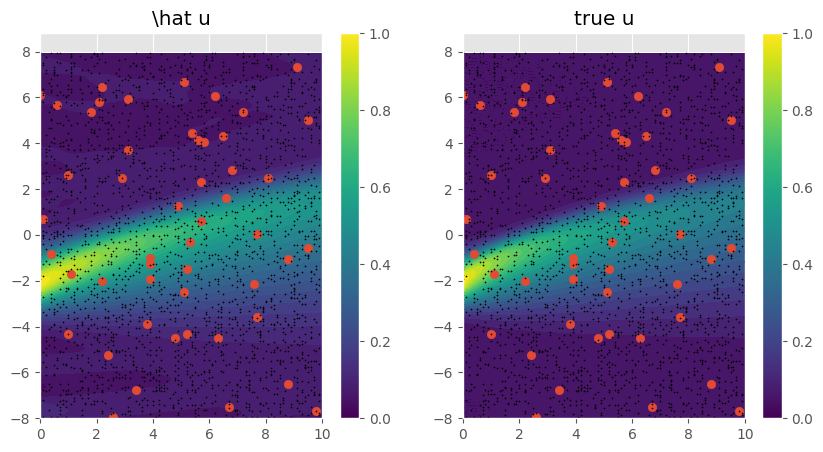

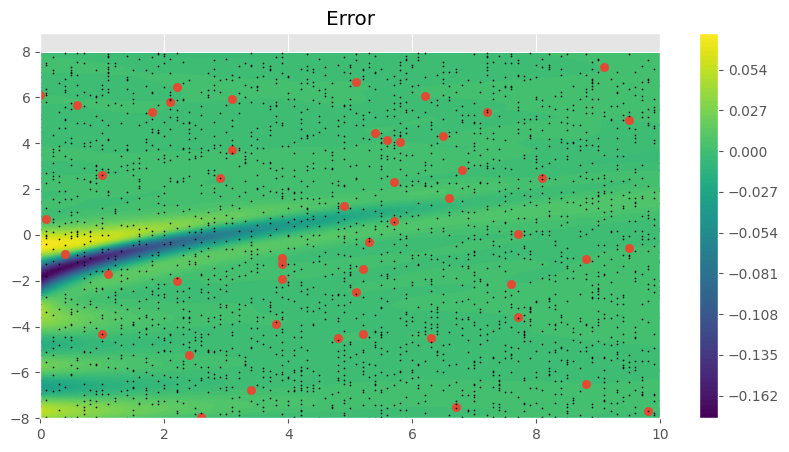

In [42]:
fine_features = EqnModel.single_eqn_features(u_model,u_sol,X_star)
input_features = EqnModel.single_eqn_features(u_model,u_sol,tx_all)


feature_predicted_ut = P_model.predict_new(fine_features,input_features,P_parameters)
ut_target = u_model.evaluate_operators((dt_k,),X_star,u_sol)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("$\\hat P (\\hat u)$")
plt.tricontourf(X_star[:,0],X_star[:,1],feature_predicted_ut,30)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("$\\hat u_t$")
plt.tricontourf(X_star[:,0],X_star[:,1],ut_target,30)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,5))
plt.title("$\\hat P (\\hat u) - \\hat u_t$")
plt.tricontourf(X_star[:,0],X_star[:,1],ut_target - feature_predicted_ut,100)
plt.xlim(-0.1,10.1)
# plt.ylim(-10,10)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 1)
plt.show()

print("Equation fit error norm ", jnp.linalg.norm(ut_target - feature_predicted_ut))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("\\hat u")
plt.tricontourf(X_star[:,0],X_star[:,1],u_model.point_evaluate(X_star,u_sol),30)
plt.scatter(tx_obs[:,0],tx_obs[:,1])
plt.scatter(tx_all[:,0],tx_all[:,1],s=0.5,c='black')
plt.colorbar()
plt.subplot(1,2,2)
plt.title("true u")
plt.tricontourf(X_star[:,0],X_star[:,1],u_true,30)
plt.scatter(tx_obs[:,0],tx_obs[:,1])
plt.scatter(tx_all[:,0],tx_all[:,1],s=0.5,c='black')
plt.colorbar()
plt.show()

error = u_model.point_evaluate(X_star,u_sol) - u_true

plt.figure(figsize=(10,5))
plt.title("Error")
plt.tricontourf(X_star[:,0],X_star[:,1],error,100)
plt.colorbar()
plt.scatter(tx_obs[:,0],tx_obs[:,1])
plt.scatter(tx_all[:,0],tx_all[:,1],s=0.5,c='black')
plt.show()


In [43]:
jnp.linalg.norm(error)/jnp.linalg.norm(u_true)

Array(0.07469682, dtype=float64)